# Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import pathlib
import tensorflow as tf
import seaborn as sn
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical, plot_model, image_dataset_from_directory
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, RandomContrast, RandomRotation, RandomZoom, RandomFlip

# Load the data

In [ ]:
data_dir = pathlib.Path("/content/drive/MyDrive/Dataset /archive (2)/dataset")
data = image_dataset_from_directory(data_dir, seed = 123, image_size=(224, 224))
class_names = data.class_names

Found 4227 files belonging to 4 classes.


# Data distribution

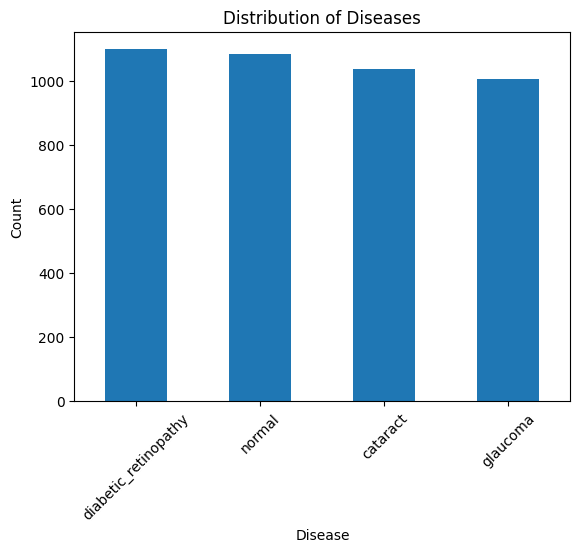

In [ ]:
# Data distribution
labels = np.concatenate([y for x, y in data], axis=0)
values = pd.value_counts(labels)

# Map numeric labels to class names
values.index = values.index.map(lambda x: class_names[x])

# Plot the data distribution
values.plot(kind='bar')
plt.xlabel('Disease')
plt.ylabel('Count')
plt.title('Distribution of Diseases')
plt.xticks(rotation=45)
plt.show()

# Image samples

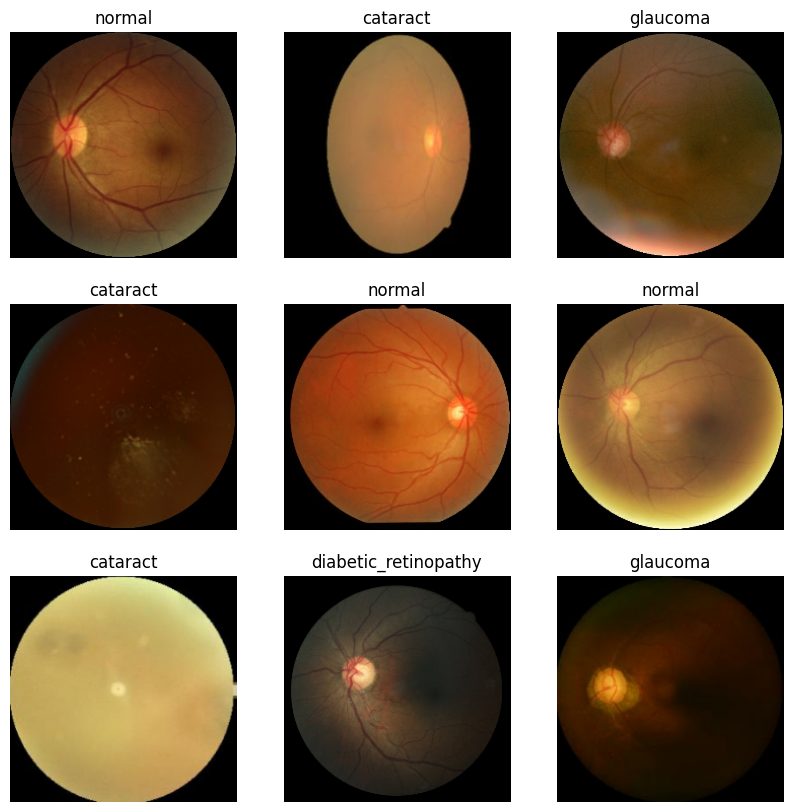

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(data.class_names[labels[i]])
        plt.axis("off")

# Splitting the data

In [ ]:
data = data.map(lambda x, y: (x/255, y))
train_size = int(0.7 * len(data)) +1
val_size = int(0.2 * len(data))
test_size = int(0.1 * len(data))
train = data.take(train_size)
remaining = data.skip(train_size)
val = remaining.take(val_size)
test = remaining.skip(val_size)

In [ ]:
test_iter = test.as_numpy_iterator()
test_set = {"images":np.empty((0,224,224,3)), "labels":np.empty(0)}
while True:
    try:
        batch = test_iter.next()
        test_set['images'] = np.concatenate((test_set['images'], batch[0]))
        test_set['labels'] = np.concatenate((test_set['labels'], batch[1]))
    except:
        break
y_test = test_set['labels']

In [ ]:
def evaluate_model(model):
    model.evaluate(test)
    y_pred = np.argmax(model.predict(test_set['images']), 1)
    print(classification_report(y_test, y_pred, target_names = class_names))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sn.heatmap(cm, annot=True)
    plt.xticks(np.arange(4)+.5, class_names, rotation=90)
    plt.yticks(np.arange(4)+.5, class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

# Create the CNN model

In [ ]:
model = Sequential([
        Conv2D(64, (3,3), activation = 'relu',padding='same', input_shape=(224,224,3)),
        Conv2D(64, (3,3), activation = 'relu',padding='same'),
        Conv2D(64, (3,3), activation = 'relu',padding='same'),
        MaxPool2D(),
        Conv2D(128, (3,3), padding='same', activation = 'relu'),
        Conv2D(128, (3,3),padding='same', activation = 'relu'),
        Conv2D(128, (3,3), activation = 'relu',padding='same'),
        MaxPool2D(),
        Flatten(),
        Dense(256, activation = 'relu'),
        Dense(4, activation='softmax')
    ])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 128)     147584    
                                                        

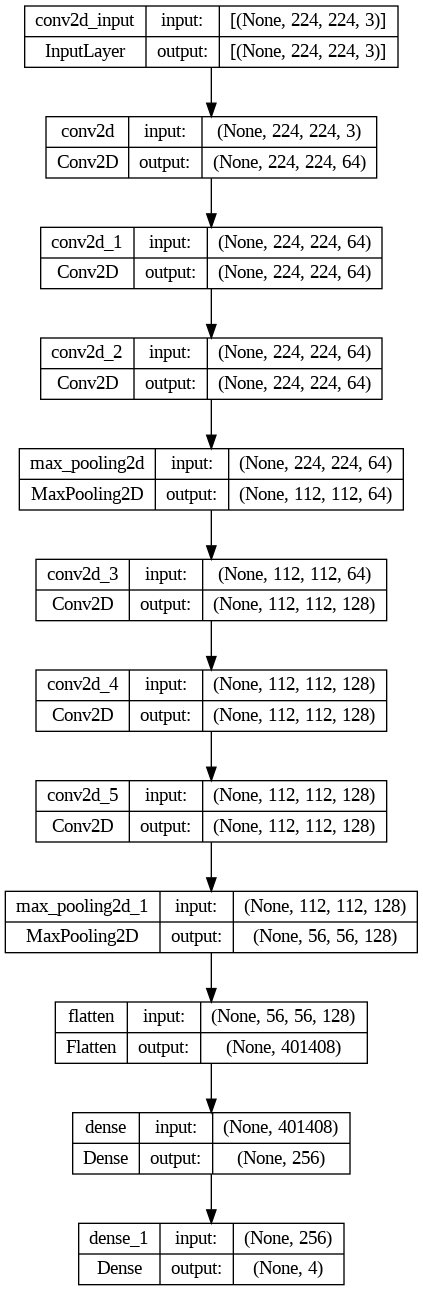

In [ ]:
plot_model(model, to_file='simple-cnn.png', show_shapes=True)

## Train the model

In [ ]:
history = model.fit(train, validation_data=val, epochs = 12)

Epoch 1/12
93/93 [==============================] - 93s 817ms/step - loss: 1.3722 - accuracy: 0.4251 - val_loss: 0.8651 - val_accuracy: 0.5781
Epoch 2/12
93/93 [==============================] - 77s 808ms/step - loss: 0.8060 - accuracy: 0.6243 - val_loss: 0.6550 - val_accuracy: 0.7200
Epoch 3/12
93/93 [==============================] - 77s 812ms/step - loss: 0.6747 - accuracy: 0.6959 - val_loss: 0.6071 - val_accuracy: 0.7248
Epoch 4/12
93/93 [==============================] - 77s 810ms/step - loss: 0.5966 - accuracy: 0.7288 - val_loss: 0.5782 - val_accuracy: 0.7151
Epoch 5/12
93/93 [==============================] - 78s 814ms/step - loss: 0.5527 - accuracy: 0.7503 - val_loss: 0.5492 - val_accuracy: 0.7596
Epoch 6/12
93/93 [==============================] - 77s 811ms/step - loss: 0.5391 - accuracy: 0.7574 - val_loss: 0.5109 - val_accuracy: 0.7632
Epoch 7/12
93/93 [==============================] - 80s 820ms/step - loss: 0.5168 - accuracy: 0.7765 - val_loss: 0.5173 - val_accuracy: 0.7560

## Check the performance of the model

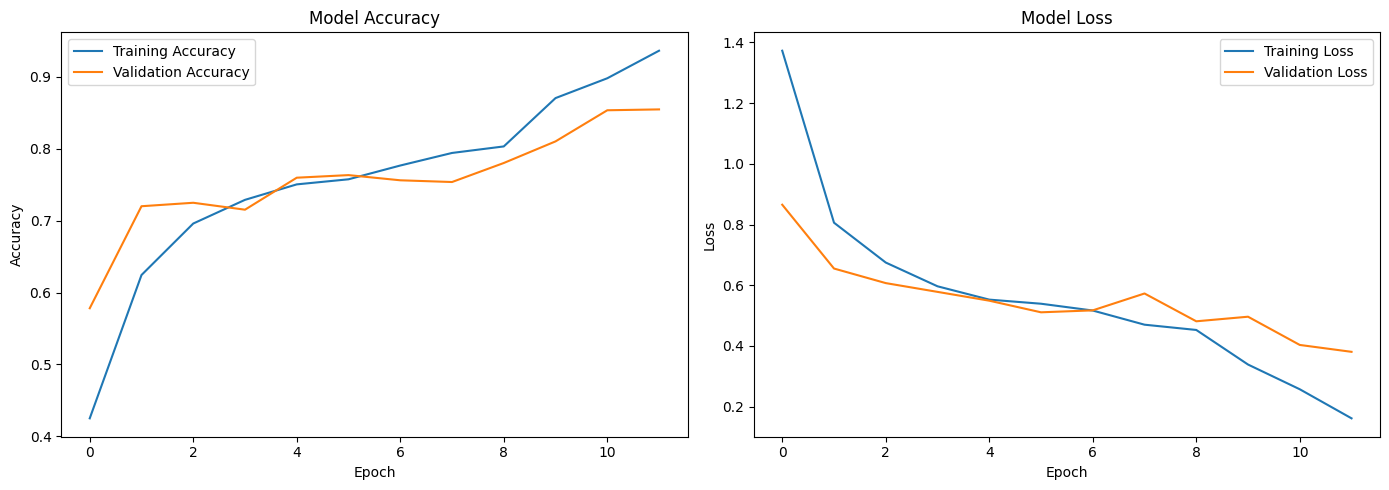

In [ ]:
def plot_performance(history):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot training & validation accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Plot training & validation loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()

# Call the plot_performance function with your training history
plot_performance(history)




13/13 [==============================] - 1s 101ms/step
                      precision    recall  f1-score   support

            cataract       0.73      0.85      0.79        93
diabetic_retinopathy       1.00      0.99      1.00       105
            glaucoma       0.78      0.63      0.70       106
              normal       0.84      0.89      0.86       105

            accuracy                           0.84       409
           macro avg       0.84      0.84      0.84       409
        weighted avg       0.84      0.84      0.84       409



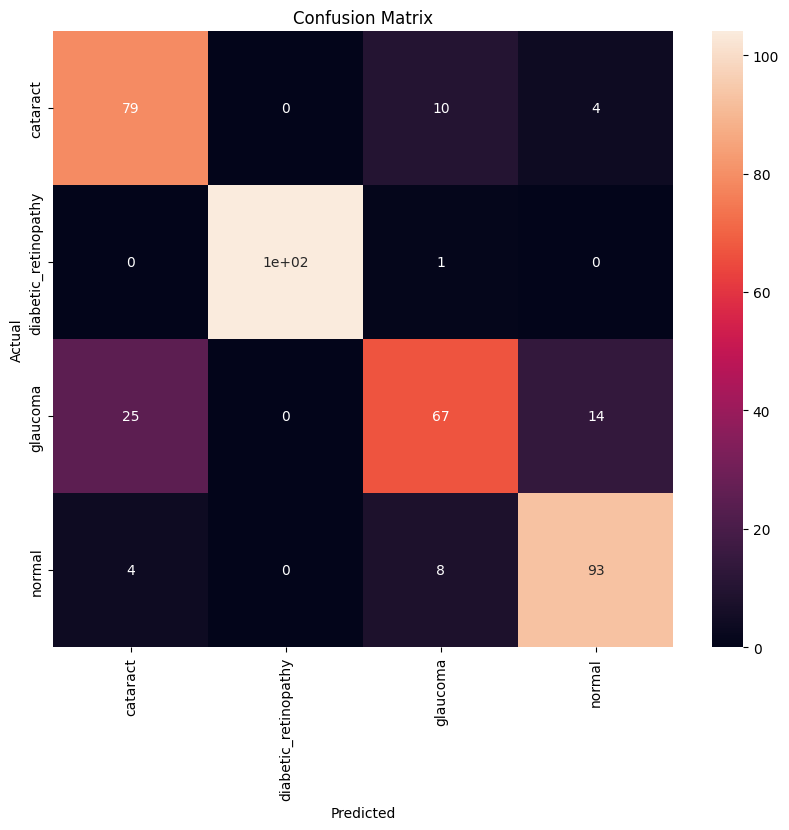

In [ ]:
evaluate_model(model)

# Explaining predictions with LIME

In [ ]:
!pip install lime

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=cb45023feb99e6b41833f3a1cfca9749fb11fc59e6c6f70558e100d04461caf1
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
from tensorflow.keras.preprocessing import image
from skimage.io import imread
from skimage.transform import resize

def predict_image(image_path):
    img = imread(image_path)
    img = resize(img, (224,224))

    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    preds = model.predict(img)
    prediction = np.argmax(preds)
    pct = np.max(preds)
    if prediction == 0:
        print('Cataract')
    elif prediction == 1:
        print('Diabetic retinopathy')
    elif prediction == 2:
        print('Glaucoma')
    else:
        print('Normal')
    print(pct)
    return img

In [ ]:
def explain_prediction(image_path):
    img = predict_image(image_path)
    explainer = lime_image.LimeImageExplainer(random_state=12)
    explanation = explainer.explain_instance(
             img[0].astype('double'),
             model.predict
    )
    from skimage.segmentation import mark_boundaries

    temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
    ax1.imshow(mark_boundaries(temp_1, mask_1))
    ax2.imshow(mark_boundaries(temp_2, mask_2))
    ax1.axis('off')
    ax2.axis('off')

1/1 [==============================] - 1s 987ms/step
Glaucoma
0.97985876


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


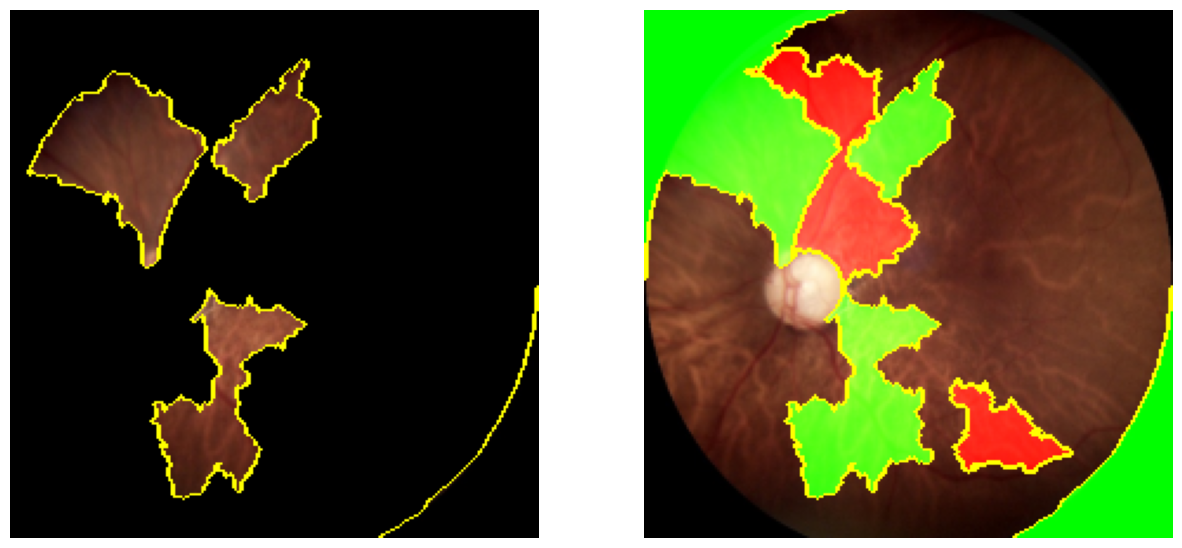

In [ ]:
explain_prediction("/content/drive/MyDrive/archive (2)/dataset/glaucoma/1212_left.jpg")

1/1 [==============================] - 0s 27ms/step
Glaucoma
0.98920363


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


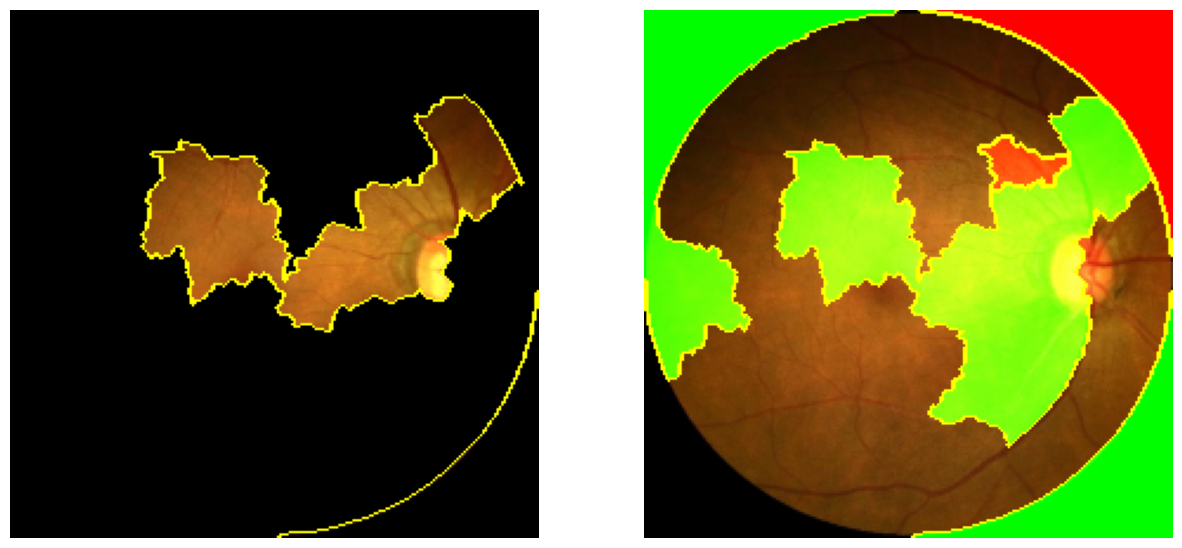

In [ ]:
explain_prediction("/content/drive/MyDrive/archive (2)/dataset/glaucoma/1389_right.jpg")

1/1 [==============================] - 0s 18ms/step
Glaucoma
0.9833124


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


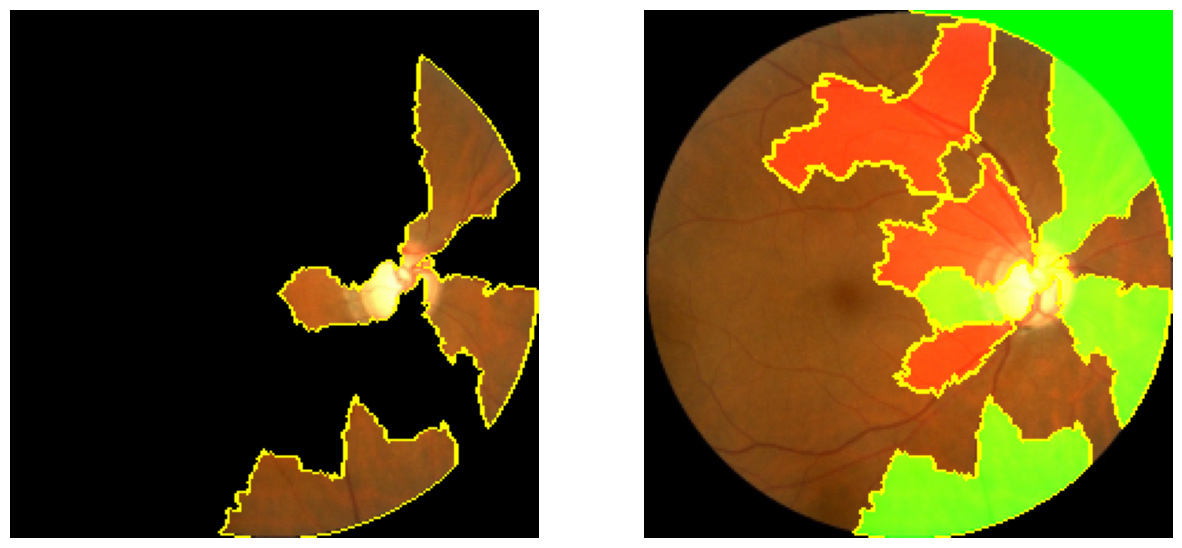

In [ ]:
explain_prediction("/content/drive/MyDrive/archive (2)/dataset/glaucoma/1220_right.jpg")

# Transfer learning

## DensetNet121

In [ ]:
from tensorflow.keras.applications import DenseNet121
dense = DenseNet121(weights = "imagenet", include_top = False, input_shape=(224,224,3))
for layer in dense.layers[:121]:
    layer.trainable = False

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
model = Sequential([
    dense,
    MaxPool2D(2),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(4, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 1024)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 3, 3, 1024)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                        

In [ ]:
history = model.fit(train,validation_data=val,epochs = 12)

Epoch 1/12
94/94 [==============================] - 122s 752ms/step - loss: 0.8439 - accuracy: 0.7992 - val_loss: 0.4349 - val_accuracy: 0.8822
Epoch 2/12
94/94 [==============================] - 72s 746ms/step - loss: 0.2631 - accuracy: 0.9029 - val_loss: 0.3803 - val_accuracy: 0.9099
Epoch 3/12
94/94 [==============================] - 72s 750ms/step - loss: 0.1828 - accuracy: 0.9282 - val_loss: 0.2534 - val_accuracy: 0.9267
Epoch 4/12
94/94 [==============================] - 73s 754ms/step - loss: 0.2548 - accuracy: 0.9192 - val_loss: 3.0283 - val_accuracy: 0.7548
Epoch 5/12
94/94 [==============================] - 72s 744ms/step - loss: 0.2350 - accuracy: 0.9259 - val_loss: 37.5950 - val_accuracy: 0.2656
Epoch 6/12
94/94 [==============================] - 71s 742ms/step - loss: 0.1613 - accuracy: 0.9435 - val_loss: 0.5349 - val_accuracy: 0.8666
Epoch 7/12
94/94 [==============================] - 71s 744ms/step - loss: 0.1226 - accuracy: 0.9588 - val_loss: 0.2925 - val_accuracy: 0.92

In [ ]:
model.save('model3.h5')

In [ ]:
model.save("/content/drive/MyDrive/model3.h5")

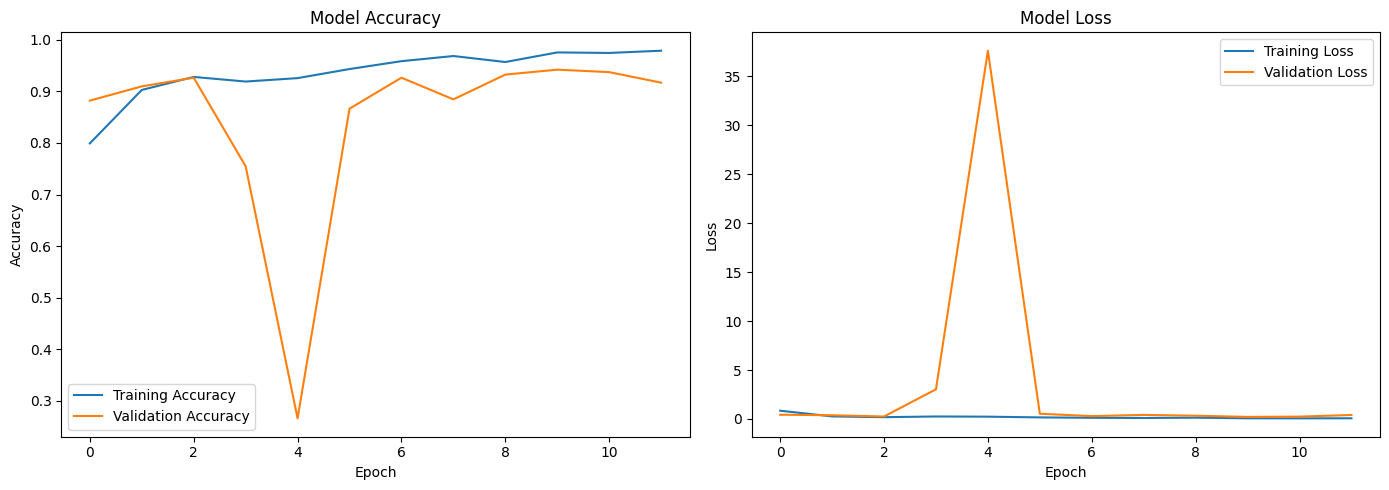

In [ ]:
def plot_performance(history):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot training & validation accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Plot training & validation loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()

# Call the plot_performance function with your training history
plot_performance(history)

13/13 [==============================] - 4s 89ms/step
                      precision    recall  f1-score   support

            cataract       0.96      0.93      0.95        92
diabetic_retinopathy       1.00      1.00      1.00       101
            glaucoma       0.99      0.72      0.83        96
              normal       0.78      1.00      0.88        98

            accuracy                           0.91       387
           macro avg       0.93      0.91      0.91       387
        weighted avg       0.93      0.91      0.91       387



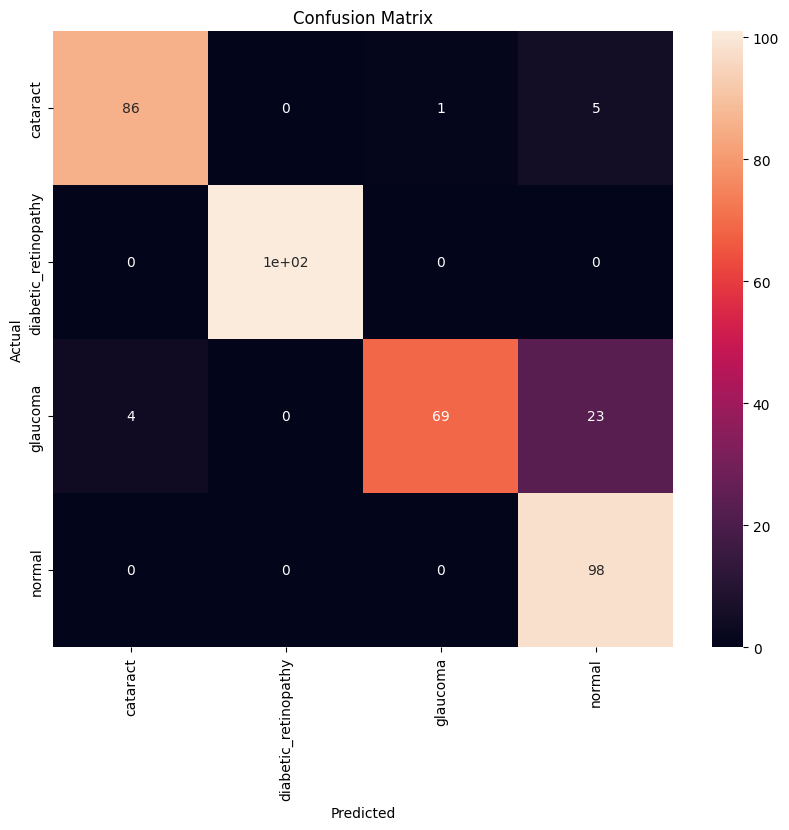

In [ ]:
evaluate_model(model)

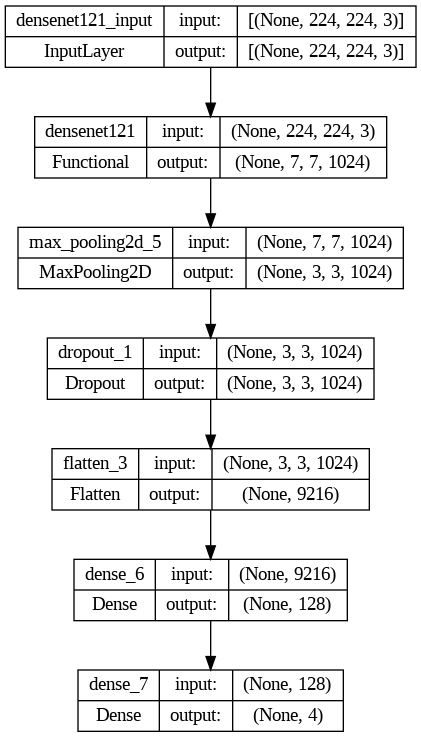

In [ ]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model, to_file='densenet.png', show_shapes=True)

## VGG16

In [ ]:
#from keras.applications.vgg16 import VGG16
#vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
#for layer in vgg16.layers:
    #layer.trainable = False
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))


58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
#model = Sequential([
    #vgg16,
    #Flatten(),
    #Dropout(0.5),
    #Dense(128, activation = 'relu'),
    #Dense(4, activation='softmax')
#])
#model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Define your model architecture
model = Sequential([
    vgg16,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])

# Set earlier layers of VGG16 to be non-trainable
for layer in vgg16.layers[:-4]:
    layer.trainable = False

# Compile the model
optimizer = Adam(lr=0.0001)  # Lowering the learning rate
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [ ]:

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 17926596 (68.38 MB)
Trainable params: 10291332 (39.26 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


In [ ]:
#history = model.fit(train,validation_data=val,epochs = 12)
history = model.fit(
    train,
    validation_data=val,
    epochs=20,  # Increase epochs
    steps_per_epoch=len(train),
    validation_steps=len(val)
)


Epoch 1/20
94/94 [==============================] - 79s 687ms/step - loss: 1.3199 - accuracy: 0.3986 - val_loss: 0.9665 - val_accuracy: 0.5613
Epoch 2/20
94/94 [==============================] - 67s 690ms/step - loss: 1.1467 - accuracy: 0.4199 - val_loss: 1.0374 - val_accuracy: 0.5829
Epoch 3/20
94/94 [==============================] - 66s 693ms/step - loss: 1.0272 - accuracy: 0.4704 - val_loss: 0.8253 - val_accuracy: 0.5962
Epoch 4/20
94/94 [==============================] - 67s 691ms/step - loss: 0.9085 - accuracy: 0.5319 - val_loss: 0.6737 - val_accuracy: 0.6839
Epoch 5/20
94/94 [==============================] - 67s 700ms/step - loss: 0.6650 - accuracy: 0.6958 - val_loss: 0.5553 - val_accuracy: 0.7885
Epoch 6/20
94/94 [==============================] - 67s 698ms/step - loss: 0.5100 - accuracy: 0.7955 - val_loss: 0.4707 - val_accuracy: 0.8293
Epoch 7/20
94/94 [==============================] - 67s 696ms/step - loss: 0.4248 - accuracy: 0.8378 - val_loss: 0.4486 - val_accuracy: 0.8401

In [ ]:
model.save('model3.h5')

In [ ]:
model.save("/content/drive/MyDrive/model3.h5")

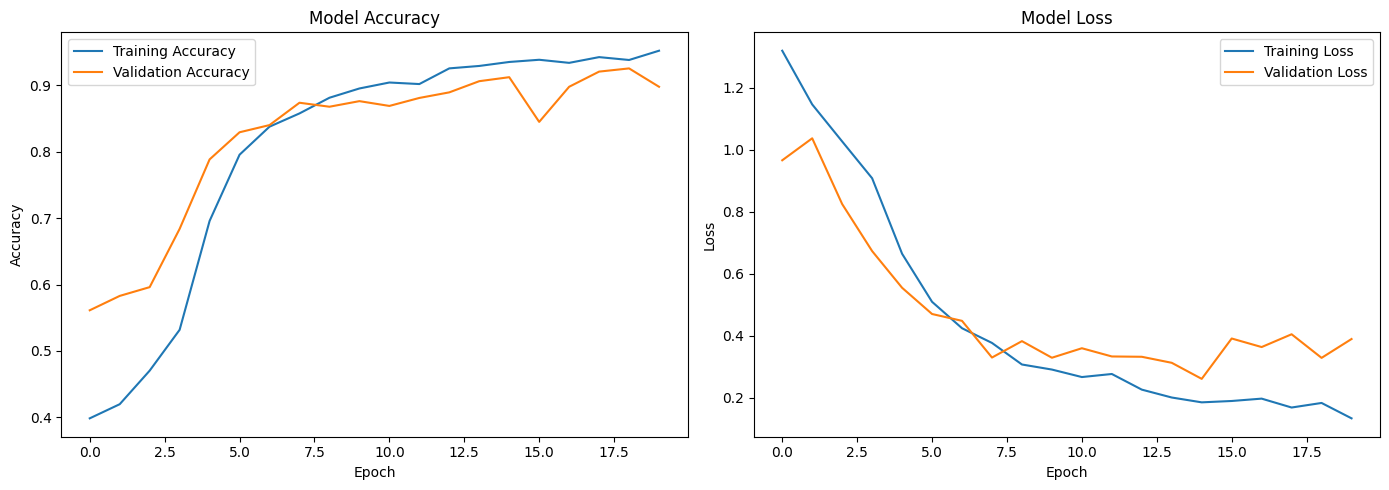

In [ ]:
def plot_performance(history):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot training & validation accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Plot training & validation loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()

# Call the plot_performance function with your training history
plot_performance(history)

13/13 [==============================] - 2s 140ms/step
                      precision    recall  f1-score   support

            cataract       0.82      0.95      0.88        93
diabetic_retinopathy       0.99      1.00      1.00       105
            glaucoma       0.78      0.80      0.79       106
              normal       0.94      0.78      0.85       105

            accuracy                           0.88       409
           macro avg       0.88      0.88      0.88       409
        weighted avg       0.89      0.88      0.88       409



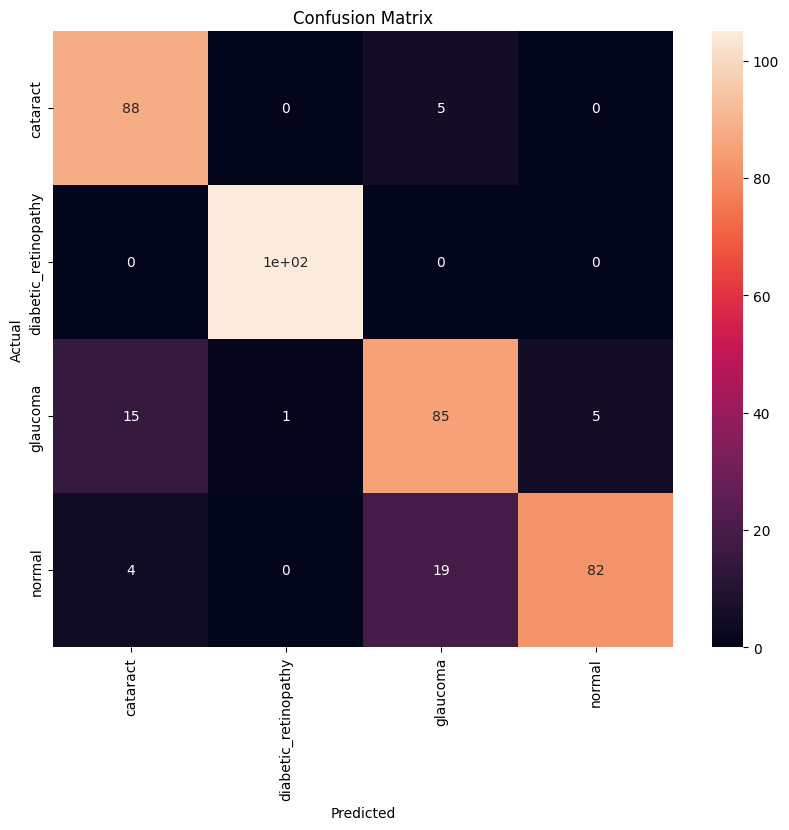

In [ ]:
evaluate_model(model)

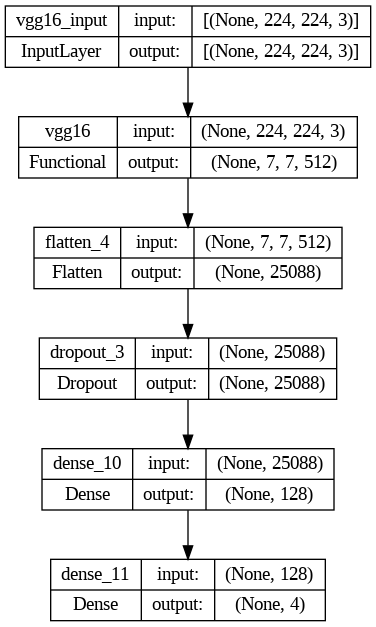

In [ ]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model, to_file='vgg16.png', show_shapes=True)

MobileNetV2

In [ ]:
from keras.applications import MobileNet
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

# Load pre-trained MobileNet model
mobilenet = MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3))


17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
# Define your model architecture
model = Sequential([
    mobilenet,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])

# Set earlier layers of MobileNet to be non-trainable
for layer in mobilenet.layers[:-4]:
    layer.trainable = False

# Compile the model
optimizer = Adam(lr=0.0001)  # Lowering the learning rate
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

In [ ]:
# Assuming 'train' and 'val' are your ImageDataGenerator flow_from_directory objects
history = model.fit(
    train,
    validation_data=val,
    epochs=20,  # Increase epochs
    steps_per_epoch=len(train),
    validation_steps=len(val)
)

Epoch 1/20
94/94 [==============================] - 69s 682ms/step - loss: 1.6215 - accuracy: 0.7856 - val_loss: 0.8209 - val_accuracy: 0.7019
Epoch 2/20
94/94 [==============================] - 66s 685ms/step - loss: 0.2832 - accuracy: 0.8880 - val_loss: 0.4023 - val_accuracy: 0.8329
Epoch 3/20
94/94 [==============================] - 66s 685ms/step - loss: 0.2154 - accuracy: 0.9166 - val_loss: 0.2533 - val_accuracy: 0.9099
Epoch 4/20
94/94 [==============================] - 66s 685ms/step - loss: 0.1616 - accuracy: 0.9378 - val_loss: 0.3173 - val_accuracy: 0.8882
Epoch 5/20
94/94 [==============================] - 65s 674ms/step - loss: 0.1332 - accuracy: 0.9478 - val_loss: 0.2338 - val_accuracy: 0.9183
Epoch 6/20
94/94 [==============================] - 65s 679ms/step - loss: 0.1611 - accuracy: 0.9415 - val_loss: 0.4110 - val_accuracy: 0.8750
Epoch 7/20
94/94 [==============================] - 64s 667ms/step - loss: 0.2105 - accuracy: 0.9328 - val_loss: 6.9365 - val_accuracy: 0.5469

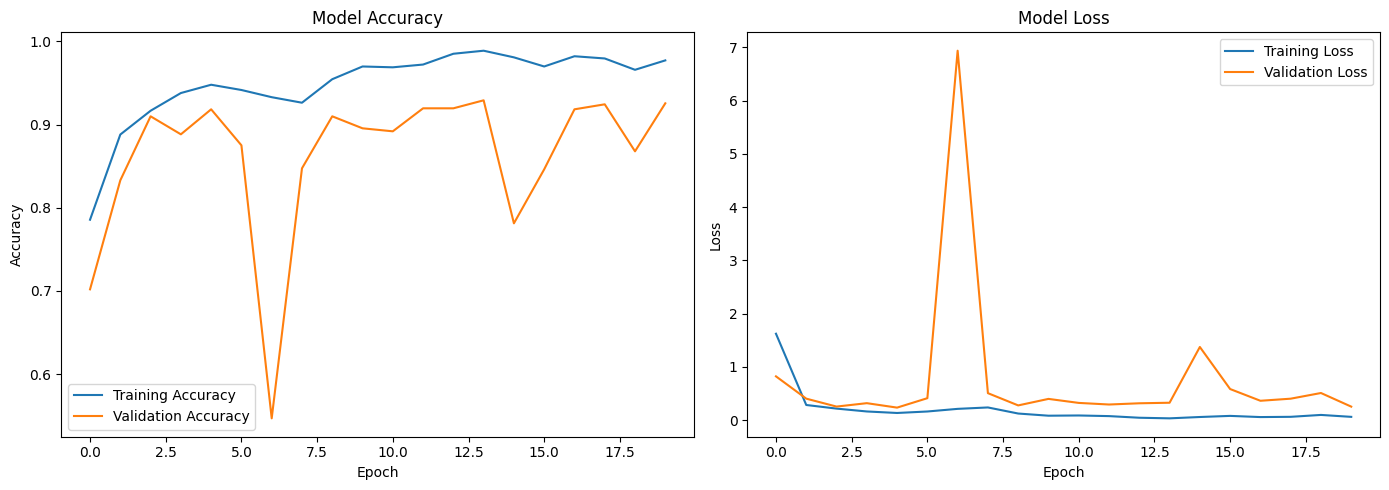

In [ ]:
def plot_performance(history):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot training & validation accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Plot training & validation loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()

# Call the plot_performance function with your training history
plot_performance(history)

13/13 [==============================] - 1s 39ms/step
                      precision    recall  f1-score   support

            cataract       0.94      0.90      0.92        92
diabetic_retinopathy       0.97      0.99      0.98       101
            glaucoma       0.82      0.91      0.86        96
              normal       0.91      0.84      0.87        98

            accuracy                           0.91       387
           macro avg       0.91      0.91      0.91       387
        weighted avg       0.91      0.91      0.91       387



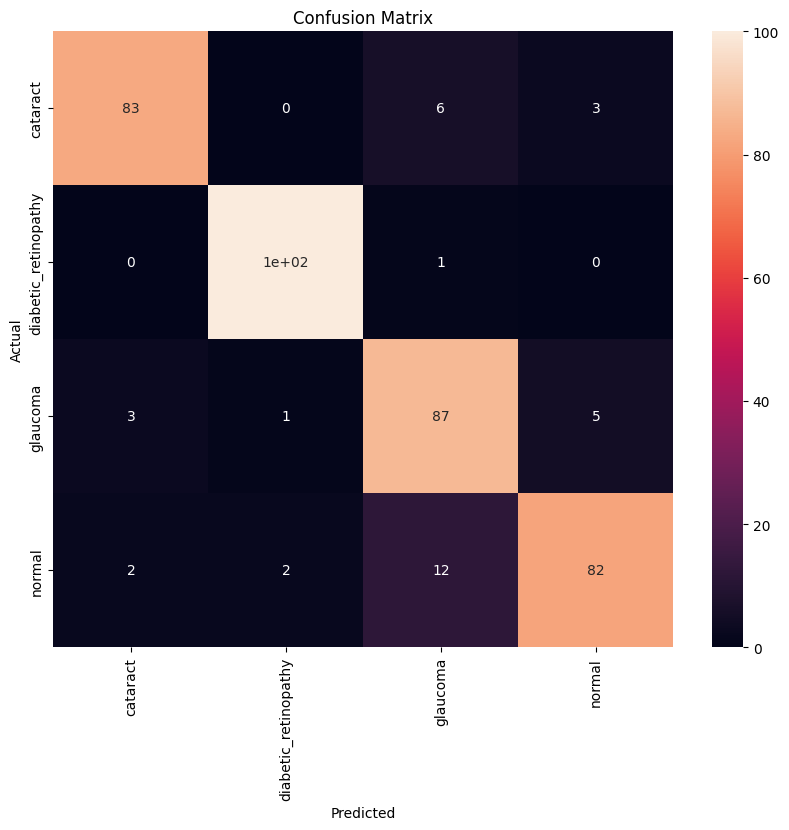

In [ ]:
evaluate_model(model)

In [ ]:
model.save('model2.h5')

In [ ]:
model.save("/content/drive/MyDrive/model2.h5")

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import xgboost as xgb

# Define the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Assuming y_test is a pandas Series
# Get correct labels from the validation dataset
target_labels = np.concatenate([y for x, y in val], axis=0)

# Step 1: Obtain Predictions from Deep Learning Models
predictions_densenet = model.predict(val)  # Use your DenseNet121-based model
predictions_mobilenet = model.predict(val)  # Use your MobileNet-based model
predictions_vgg16 = model.predict(val)      # Use your VGG16-based model

# Step 2: Prepare Data for XGBoost
xgboost_data = np.concatenate([predictions_densenet, predictions_mobilenet, predictions_vgg16], axis=1)

# Ensure both xgboost_data and target_labels have the same length
assert xgboost_data.shape[0] == len(target_labels), "Inconsistent number of samples"

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

grid_search = GridSearchCV(xgb_classifier, param_grid, cv=3, scoring='accuracy')
grid_search.fit(xgboost_data, target_labels)

# Print the best parameters found by the grid search
print("Best Parameters:", grid_search.best_params_)

# Make predictions on the validation set
y_pred_xgb_val = grid_search.predict(xgboost_data)

# Evaluate XGBoost model on the validation set
accuracy_xgb_val = accuracy_score(target_labels, y_pred_xgb_val)
print("XGBoost Accuracy on Validation Set:", accuracy_xgb_val)


26/26 [==============================] - 30s 255ms/step
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
XGBoost Accuracy on Validation Set: 0.9555288461538461


In [ ]:
from keras.models import load_model

# Save the model to a HDF5 file
model.save('keras_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('model.keras')`.
  saving_api.save_model